In [13]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
from collections import Counter
from konlpy.tag import Mecab, Okt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

In [14]:
total_dataset = pd.read_csv("train.csv")
test_dataset = pd.read_csv("test.csv")

In [15]:
total_dataset.head()

,text,category
0,이에 따른다면 초등학생들의 소비 문화는 디지털 강국의 ‘개국 공신’이 되려는 몸부림...,연예/문화
1,"""지난 14일 우리정부가 난민 신청을 한 예멘인들에 대해 인도적 체류를 허가했는데요...",연예/문화
2,인천시 서구와 계양구에서 경기도 부천을 거쳐 서울 홍대까지 지하철이 건설될 것으로 ...,생활
3,김성태 자유한국당 의원이 최근 황운하 울산경찰청장과 벌인 ‘미친개’ 공방을 언급하며...,정치
4,"""지난해 사상 최대 실적을 거뒀던 우리 수출이 새해에도 좋은 흐름을 이어갔습니다. ...",스포츠


In [16]:
len(total_dataset)

37648

In [17]:
total_dataset["text"].nunique()

35837

In [18]:
total_dataset.drop_duplicates(subset=['text'], inplace=True)

In [19]:
total_dataset.groupby('category').size().reset_index(name = 'count')

,category,count
0,경제,3659
1,사회,5471
2,생활,4956
3,스포츠,4347
4,연예/문화,10278
5,정치,7126


In [20]:
total_dataset.isnull().sum()

text        0
category    0
dtype: int64

In [21]:
train_data, test_data = train_test_split(total_dataset, test_size = 0.25, random_state = 42)
print('훈련용 리뷰의 개수 :', len(train_data))
print('테스트용 리뷰의 개수 :', len(test_data))

훈련용 리뷰의 개수 : 26877
테스트용 리뷰의 개수 : 8960


In [30]:
train_data['text'] = train_data['text'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힇 ]","")
test_data['text'] = test_data['text'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힇 ]","")

C:\Users\JH\AppData\Local\Temp\ipykernel_15252\494860855.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['text'] = train_data['text'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힇 ]","")
C:\Users\JH\AppData\Local\Temp\ipykernel_15252\494860855.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  test_data['text'] = test_data['text'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힇 ]","")


In [32]:
# 불용어 처리
stopwords_ko = pd.read_table("한국어불용어100.txt")
stopwords = stopwords_ko["이"].values
stopwords = np.append(stopwords,['이'])

In [33]:
from tqdm import tqdm 
okt = Okt()
X_train = []
for sentence in tqdm(train_data['text']):
    tokenized_sentence = okt.morphs(sentence, stem=True)
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords]
    X_train.append(tokenized_sentence)

X_test = []
for sentence in tqdm(test_data['text']):
    tokenized_sentence = okt.morphs(sentence, stem=True)
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords]
    X_test.append(tokenized_sentence)

100%|██████████████████████████████████████████████████████████████████████████████| 8960/8960 [06:32<00:00, 22.86it/s]


In [34]:
labels = ['경제','사회','생활','스포츠','연예/문화','정치']
num = 0
for label in labels:
    train_data['category'].replace(label, num, inplace=True)
    test_data['category'].replace(label, num, inplace=True)
    num += 1

In [35]:
# vocaburary 만들기
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [36]:
# ocaburary 빈도수의 따른 단어 비율 확인
threshold = 6
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)


단어 집합(vocabulary)의 크기 : 69577
등장 빈도가 5번 이하인 희귀 단어의 수: 38257
단어 집합에서 희귀 단어의 비율: 54.985124394555676
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 0.9167573798462881


In [38]:
y_train = train_data['category']
y_test = test_data['category']

In [39]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [40]:
# 빈도수에 따른 단어 제거
vocab_size = total_cnt - rare_cnt + 1
print('단어 집합의 크기 :', vocab_size)

# 빈 샘플(empty samples) 제거
drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]

# 빈 샘플들을 제거
X_train = np.delete(X_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)
print(len(X_train))
print(len(y_train))

단어 집합의 크기 : 31321
26877
26877


In [41]:
# 정수 인코딩 없는 단어는 OOV 처리
tokenizer = Tokenizer(vocab_size, oov_token = 'OOV') 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

리뷰의 최대 길이 : 9077
리뷰의 평균 길이 : 316.0591955947464


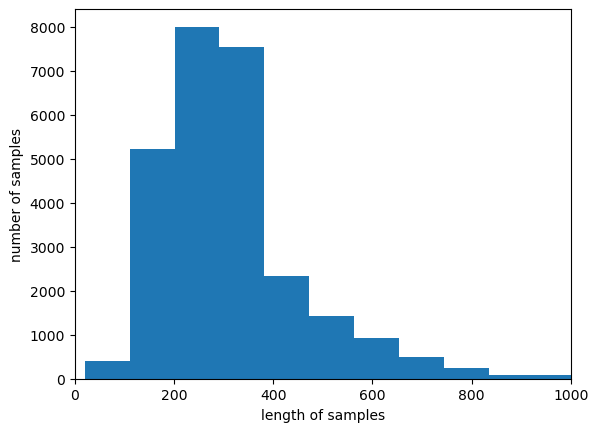

In [42]:
# 길이 확인
print('리뷰의 최대 길이 :',max(len(review) for review in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(review) for review in X_train], bins=100)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.xlim(0,1000)
plt.show()

# max_len에 따른 비율 확인
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))


In [43]:
for i in range(400, 700, 10):
    max_len = i
    below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 400 이하인 샘플의 비율: 81.11024295866353
전체 샘플 중 길이가 410 이하인 샘플의 비율: 82.21899765598839
전체 샘플 중 길이가 420 이하인 샘플의 비율: 83.21985340625814
전체 샘플 중 길이가 430 이하인 샘플의 비율: 84.15001674294005
전체 샘플 중 길이가 440 이하인 샘플의 비율: 85.00576701268743
전체 샘플 중 길이가 450 이하인 샘플의 비율: 85.88384120251517
전체 샘플 중 길이가 460 이하인 샘플의 비율: 86.68750232540833
전체 샘플 중 길이가 470 이하인 샘플의 비율: 87.37210254120623
전체 샘플 중 길이가 480 이하인 샘플의 비율: 88.09018863712468
전체 샘플 중 길이가 490 이하인 샘플의 비율: 88.81571603973659
전체 샘플 중 길이가 500 이하인 샘플의 비율: 89.35893142835883
전체 샘플 중 길이가 510 이하인 샘플의 비율: 89.95795661718198
전체 샘플 중 길이가 520 이하인 샘플의 비율: 90.51605461919114
전체 샘플 중 길이가 530 이하인 샘플의 비율: 91.15972764817502
전체 샘플 중 길이가 540 이하인 샘플의 비율: 91.74014957026453
전체 샘플 중 길이가 550 이하인 샘플의 비율: 92.22383450533914
전체 샘플 중 길이가 560 이하인 샘플의 비율: 92.72240205380065
전체 샘플 중 길이가 570 이하인 샘플의 비율: 93.19864568218179
전체 샘플 중 길이가 580 이하인 샘플의 비율: 93.74186107080403
전체 샘플 중 길이가 590 이하인 샘플의 비율: 94.13625032555717
전체 샘플 중 길이가 600 이하인 샘플의 비율: 94.57528742047103
전체 샘플 중 길이가 610 이하인 샘플의 비율: 94.962

In [44]:
# 패딩
max_len = 640
below_threshold_len(max_len, X_train)

X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

전체 샘플 중 길이가 640 이하인 샘플의 비율: 95.90728131859954


In [45]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow_addons
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model

In [48]:
embedding_dim = 128
hidden_units = 128
num_classes = 6

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(LSTM(hidden_units))
model.add(Dense(num_classes, activation='softmax'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model2.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc', tensorflow_addons.metrics.F1Score(num_classes=6, average='macro')])
history = model.fit(X_train, y_train, batch_size=128, epochs=10, callbacks=[es, mc], validation_data=(X_test, y_test))

Epoch 1/10
209/210 [============================>.] - ETA: 0s - loss: 1.3041 - acc: 0.4907 - f1_score: 0.3748
Epoch 1: val_acc improved from -inf to 0.61406, saving model to best_model2.h5
210/210 [==============================] - 15s 57ms/step - loss: 1.3034 - acc: 0.4911 - f1_score: 0.3753 - val_loss: 1.0149 - val_acc: 0.6141 - val_f1_score: 0.5137
Epoch 2/10
210/210 [==============================] - ETA: 0s - loss: 0.8766 - acc: 0.6931 - f1_score: 0.6469
Epoch 2: val_acc improved from 0.61406 to 0.66451, saving model to best_model2.h5
210/210 [==============================] - 12s 59ms/step - loss: 0.8766 - acc: 0.6931 - f1_score: 0.6469 - val_loss: 0.9614 - val_acc: 0.6645 - val_f1_score: 0.6396
Epoch 3/10
210/210 [==============================] - ETA: 0s - loss: 0.6392 - acc: 0.7917 - f1_score: 0.7695
Epoch 3: val_acc improved from 0.66451 to 0.71150, saving model to best_model2.h5
210/210 [==============================] - 13s 62ms/step - loss: 0.6392 - acc: 0.7917 - f1_score:

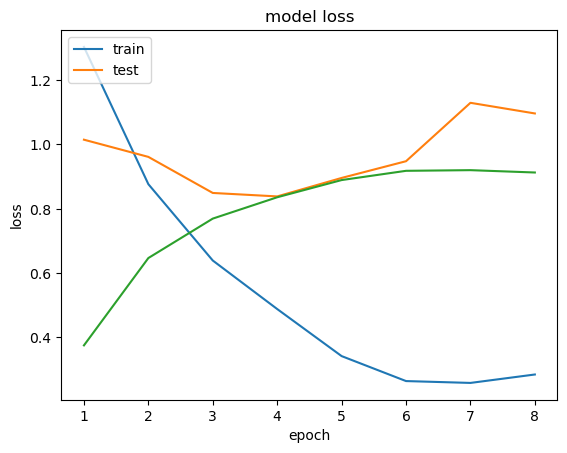

In [49]:
epochs = range(1, len(history.history['acc']) + 1)
plt.plot(epochs, history.history['loss'])
plt.plot(epochs, history.history['val_loss'])
plt.plot(epochs, history.history['f1_score'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [50]:
# 예측하기
def sentiment_predict(new_sentence):
    new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_sentence) # 순수 한글만 남기기
    new_sentence = okt.morphs(new_sentence, stem=True) # 토큰화
    encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
    pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
    y_predicted = history.model.predict(np.array(pad_new)) # 입력한 테스트용 샘플에 대해서 예측값 y를 리턴
    y_predicted = np.argmax(y_predicted, axis=-1) # 확률 벡터를 정수 레이블로 변환.
    return y_predicted[0]

In [51]:
test = test_dataset
test.head()

,ID,text
0,0,"""[기자] 지난 24일 국회 국방위원회에서 현역 대령인 기무부대장이 송영무 국방장관..."
1,1,[IMG1] 한예슬-에릭 커플의 드라마 '스파이명월'의 시청률이 3회연속 하락세를 ...
2,2,"""디지털 광장입니다. 운전대를 잡는 시간보다 구르고 넘어지는 시간이 더 많은 극한의..."
3,3,정부가 최저 임금 인상 대책으로 자영업자와 영세사업자에게 지원하는 일자리 안정자금의...
4,4,청와대가 1박2일간 숨가빴던 방북 일정을 마치고 돌아온 대북특별사절단의 후일담을 8...


In [52]:
y_pred = []
for i in range(len(test)):
    label = sentiment_predict(test.iloc[i][1])
    y_pred.append(label)

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 23ms/step


In [53]:
test["category"] = y_pred

labels = ['경제','사회','생활','스포츠','연예/문화','정치']
num = 0
for label in labels:
    test['category'].replace(num, label, inplace=True)
    num += 1
test.groupby('category').size().reset_index(name = 'count')

submission = pd.DataFrame({
    'ID' : test['ID'],
    'text' : test['text'],
    'category' : test['category']
})

submission.to_csv('submission2.csv', index=False)

In [ ]:
# F1 데이터 검증 추가